<IPython.core.display.Javascript object>


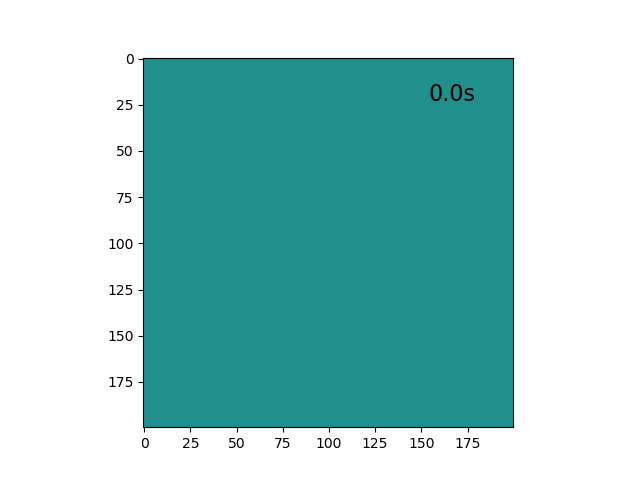

In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib nbagg
#%matplotlib inline

# パラメータの定義
nx = ny = 200  # x, y方向のグリッド数
dx = dy = 75   # x, y方向のグリッド間隔（m）
dt = 10.0 # 時間間隔（ms）
nt = 1000 # 時間ステップ数（計算される時間は dt*nt (ms)となる）
fc = 4.0  # 震源項の中心周波数（Hz）
c = 4.0   # 伝播速度（km/s = m/ms）
ieqx = int(nx/2) # 震源のグリッド位置（x方向）
ieqy = int(ny/2) # 震源のグリッド位置（y方向）
plotstep=10 # スナップショットを出力する時間ステップ間隔

a1 = -1.0/12.0
a2 = 4.0/3.0
a3 = -5.0/2.0
dtdx2 = dt*dt/(dx*dx)
dtdy2 = dt*dt/(dy*dy)

# 配列の定義
u = np.zeros((nx, ny))  # 時刻 t の波動場
u1 = np.zeros((nx, ny)) # 時刻 t - dt の波動場
u2 = np.zeros((nx, ny)) # 時刻 t - 2dt の波動場

# 震源項の設定(Ricker wavelet)
tt = (np.pi*fc*0.001*(np.arange(nt)*dt-1250.0/fc))**2
stf = (1.0-2.0*tt)*np.exp(-tt)*dt*dt

# 差分式を計算する関数
@numba.jit('(f8[:,:],f8[:,:],f8[:,:],f8[:],i8)')
def step(u, u1, u2, stf, it):
    for i in range(2, nx-2):
        for j in range(2, ny-2):
            u[i,j] = 2*u1[i,j]-u2[i,j] \
                +c*c* \
                (dtdx2*a1*(u1[i+2,j]+u1[i-2,j]) \
                +dtdx2*a2*(u1[i+1,j]+u1[i-1,j])+dtdx2*a3*u1[i,j] \
                +dtdy2*a1*(u1[i,j+2]+u1[i,j-2]) \
                +dtdy2*a2*(u1[i,j+1]+u1[i,j-1])+dtdy2*a3*u1[i,j] \
                )
    u[ieqx,ieqy] = u[ieqx,ieqy] + stf[it]
    for i in range(2, nx-2):
        for j in range(2, ny-2):
            u2[i,j] = u1[i,j]
            u1[i,j] = u[i,j]


# プロットの準備
fig = plt.figure()
ax = plt.gca()
ims = []

# 0 ~ nt まで計算を進める
for it in range(nt):
    step(u, u1, u2, stf, it)  # 差分式を計算する関数を呼び出す
    
    # 波動場のスナップショットを描画する
    if (it % plotstep) == 0:
        im = plt.imshow(u, vmin=-10, vmax=10)
        label = plt.text(0.9, 0.9, f"{it*dt*0.001:.1f}s", fontsize=16, ha='right', va='center', transform=ax.transAxes)
        ims.append([im, label])

# 描画したスナップショットを元に動画を作成する．
ani = animation.ArtistAnimation(fig, ims, interval=1000/24)
# ani.save('scalar.mp4', writer="ffmpeg") # ffmpegがあれば動画作成可能
plt.show() # スナップショットを表示する